In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

In [2]:
data_path = "data/data_complete.csv"

data = pd.read_csv(data_path, index_col=1, parse_dates=True)
data = data.iloc[:, 1:]

# scaler_x = MinMaxScaler(feature_range=(1, 2))
# scaler_y = MinMaxScaler(feature_range=(1, 2))
# scaled_data = scaler_x.fit_transform(data.iloc[:, 0].values.reshape(-1, 1))
# data["y"] = scaled_data
data["log_y"] = np.log(data["y"])


C:\Users\keipj\AppData\Local\Temp\ipykernel_12400\306710563.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv(data_path, index_col=1, parse_dates=True)


In [3]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
column = "y"
Ntest = 29
train = data.iloc[:-Ntest]
test = data.iloc[-Ntest:]

def plot_fit_and_forecast_int(result, d, col="y"):
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.plot(data[col], label="data")

    train_pred = result.predict(start=train.index[d], end=train.index[-1])
    
    ax.plot(train.index[d:], train_pred, color="green", label="fitted")

    prediction_result = result.get_forecast(Ntest)
    conf_int = prediction_result.conf_int()
    lower, upper = conf_int[f"lower {col}"], conf_int[f"upper {col}"]
    forecast = prediction_result.predicted_mean
    ax.plot(test.index, forecast, label="forecast")
    ax.fill_between(test.index, lower, upper, color="red", alpha=0.3)
    ax.legend()


def r2(result, is_logged):
    forecast = result.forecast(Ntest).to_numpy()
    if is_logged:
        forecast = np.exp(forecast)

    t = test["y"]
    y = forecast
    return r2_score(t, y)
# data[column].plot(figsize=(20, 8));


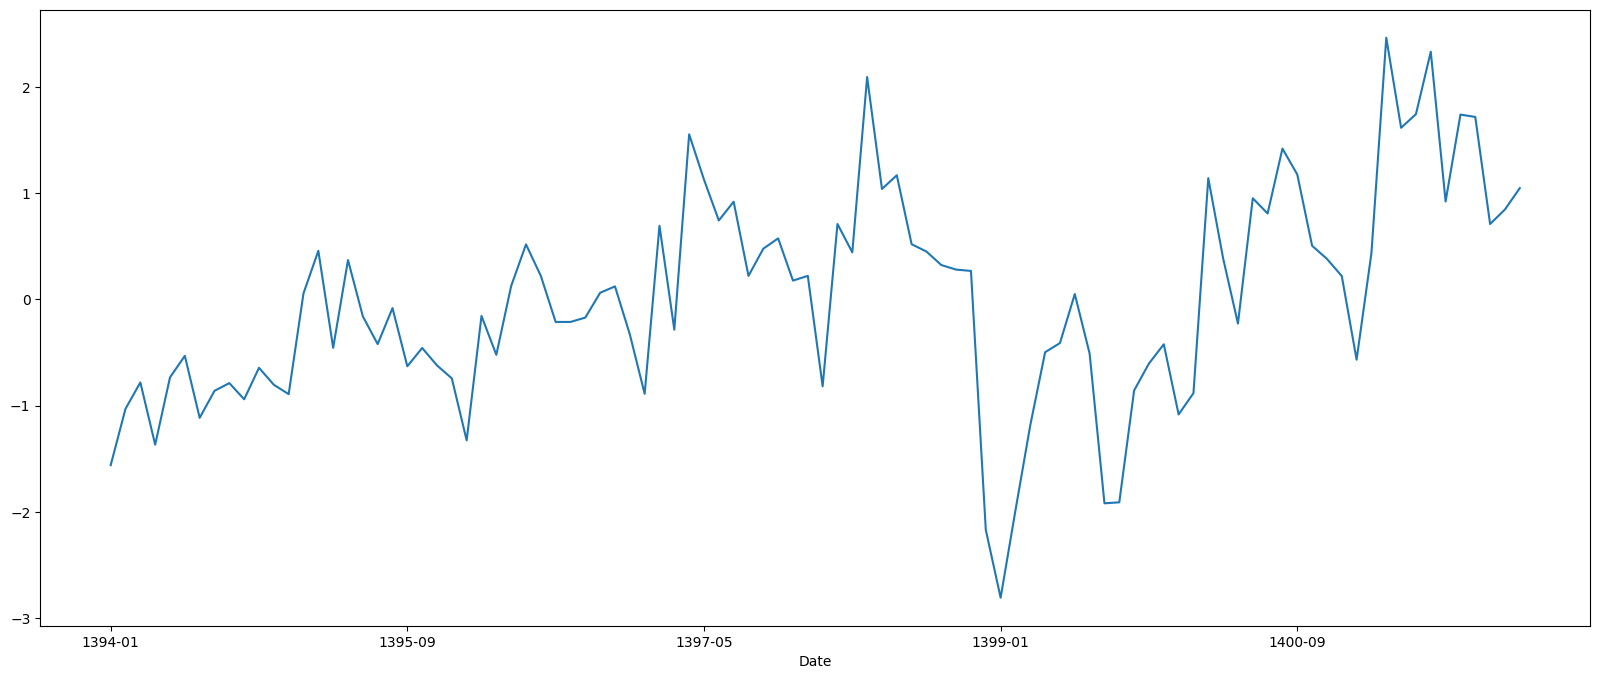

In [4]:
from sklearn.preprocessing import PowerTransformer
scaler = PowerTransformer(method="box-cox")
data["new"] = scaler.fit_transform(np.array(data["y"]).reshape(-1, 1))
data["new"].plot(figsize=(20, 8));

In [5]:
import numpy as np
def f1(x):
    return np.log(np.log(x+1)+1)

def f2(x):
    return np.exp(np.exp(x)-1)-1

In [6]:
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
scaler_x = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))
scaler_xx = FunctionTransformer(func=f1, inverse_func=f2)
scaler_yy = FunctionTransformer(func=f1, inverse_func=f2)
train[column] = scaler_x.fit_transform(np.array(train[column]).reshape(-1, 1))
test[column] = scaler_y.fit_transform(np.array(test[column]).reshape(-1, 1))
train[column] = scaler_xx.fit_transform(np.array(train[column]).reshape(-1, 1))
test[column] = scaler_yy.fit_transform(np.array(test[column]).reshape(-1, 1))


C:\Users\keipj\AppData\Local\Temp\ipykernel_12400\2977900728.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[column] = scaler_x.fit_transform(np.array(train[column]).reshape(-1, 1))
C:\Users\keipj\AppData\Local\Temp\ipykernel_12400\2977900728.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[column] = scaler_y.fit_transform(np.array(test[column]).reshape(-1, 1))
C:\Users\keipj\AppData\Local\Temp\ipykernel_12400\2977900728.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy 

## ARIMA

In [7]:
import pmdarima as pm

In [8]:
logmodel = pm.auto_arima(train[column],
                         trace=True,
                         suppress_warning=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-175.056, Time=0.74 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-144.119, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-180.445, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-170.081, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=65.924, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-178.864, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-178.803, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-176.958, Time=0.24 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-168.107, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 1.357 seconds


c:\All Python Projects\Interpreters\in_Machine_Learning\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\All Python Projects\Interpreters\in_Machine_Learning\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


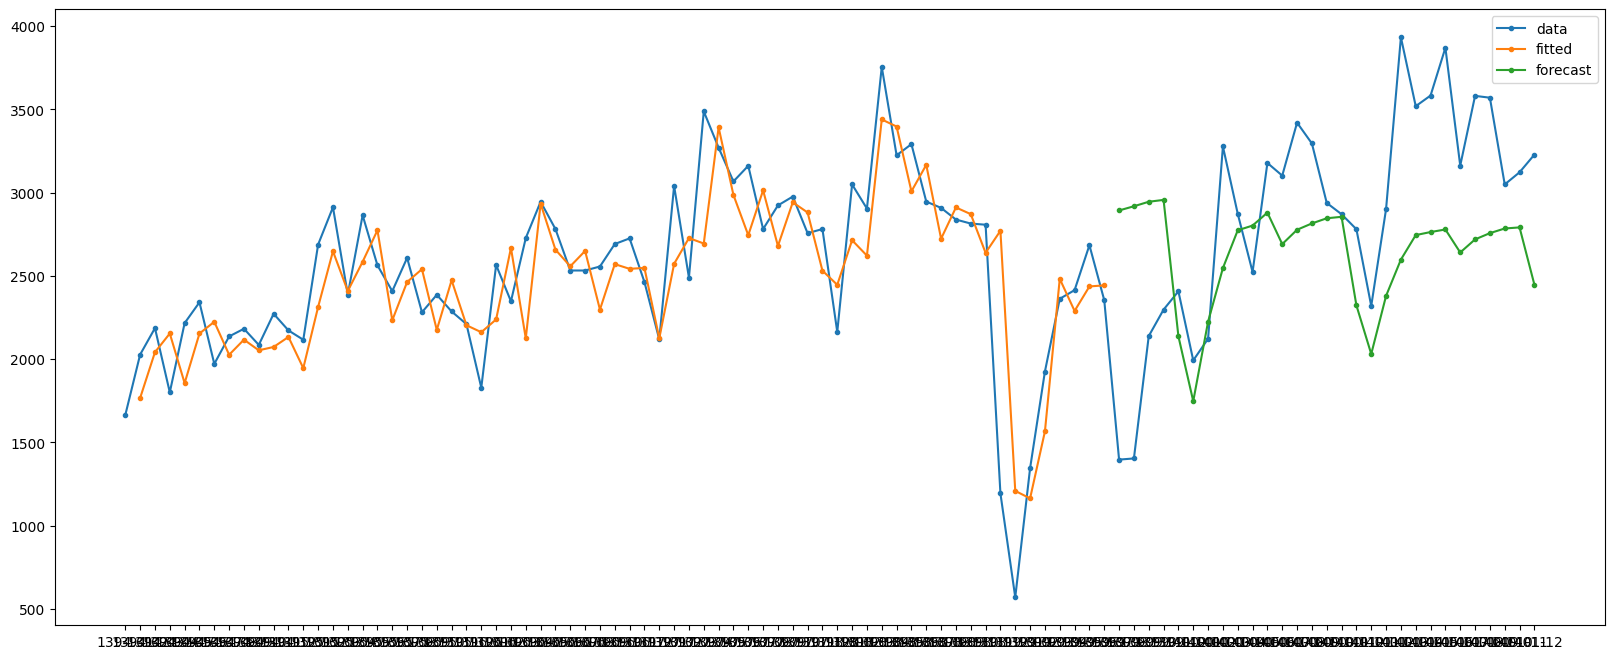

In [120]:
test_pred = logmodel.predict(n_periods=Ntest)
test_pred = scaler_yy.inverse_transform(np.array(test_pred).reshape(-1, 1))
test_pred = scaler_y.inverse_transform(np.array(test_pred).reshape(-1, 1))
train_pred = logmodel.predict_in_sample(start=1, end=-1)
train_pred = scaler_xx.inverse_transform(np.array(train_pred).reshape(-1, 1))
train_pred = scaler_x.inverse_transform(np.array(train_pred).reshape(-1, 1))
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(data.index, data[column], label="data", marker=".")
ax.plot(train.index[1:], train_pred, label="fitted",marker=".")
ax.plot(test.index, test_pred, label="forecast",marker=".")
ax.legend();

In [121]:
def mse(t, y):
    return np.mean((t-y)**2)

print("MSE test:", mse(np.array(data[column])[-Ntest:], test_pred))
print("MSE train:", mse(np.array(data[column])[:-Ntest], train_pred))

RMSE test: 574077.0858266248
RMSE train: 475108.2339261179
